# Synthetic Validation

## Import Statement :

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import cv2, collections, numpy, math, pandas, scipy.integrate

import openalea.phenomenal.data as phm_data 
import openalea.phenomenal.object as phm_obj
import openalea.phenomenal.multi_view_reconstruction as phm_mvr
import openalea.phenomenal.mesh as phm_mesh
import openalea.phenomenal.display as phm_display
import openalea.phenomenal.display.notebook as phm_display_notebook
import openalea.phenomenal.segmentation as phm_seg

## 1. Import synthetic data

### 1.1 Select plant_number

In [2]:
vertices, faces, meta_data = phm_data.synthetic_plant("data/synthetic_plant_1")

### 1.2 Viewing

In [3]:
phm_display_notebook.show_syntehtic_plant(vertices, faces, meta_data=None)

## 2. Phenomenal Measurements

### 2.1 Projection & binairies images

In [5]:
image_shape = (2448, 2048)
angles = range(0, 360, 30)
calibrations = phm_data.calibrations("data/plant_1")

selected = [("side", angle, (2448, 2048)) for angle in range(0, 360, 30)]
selected.append(("top", 0, (2048, 2448)))


bin_images = collections.defaultdict(dict)
for id_camera, angle, image_shape in selected:
    projection = calibrations[id_camera].get_projection(angle)
    image = phm_mesh.project_mesh_on_image(vertices, faces, image_shape, projection)
    bin_images[id_camera][angle] = image

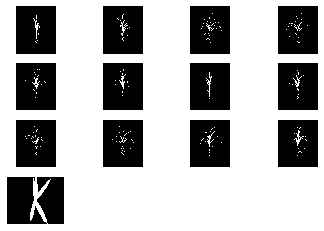

In [6]:
# Display it
phm_display.show_images(
    list(bin_images['side'].values()) + 
    list(bin_images['top'].values()))

### 2.2 Multi-view reconstruction

#### 2.2.1 Associate images and projection function

In [7]:
def routine_select_ref_angle(bin_side_images):

    max_len = 0
    max_angle = None
    
    for angle in bin_side_images:
    
        x_pos, y_pos, x_len, y_len = cv2.boundingRect(cv2.findNonZero(bin_side_images[angle]))

        if x_len > max_len:
            max_len = x_len
            max_angle = angle

    return max_angle

In [8]:
refs_angle_list = [routine_select_ref_angle(bin_images["side"])]

image_views = list()
for id_camera in bin_images:
    for angle in bin_images[id_camera]:
        projection = calibrations[id_camera].get_projection(angle)
    
        image_ref = None
        if id_camera == "side" and angle in refs_angle_list:
            image_ref = bin_images[id_camera][angle]
        
        inclusive = False
        if id_camera == "top":
            inclusive = True
            
        image_views.append(phm_obj.ImageView(
            bin_images[id_camera][angle], 
            projection, 
            inclusive=inclusive, 
            image_ref=image_ref))

#### 2.2.2 Do the mul-view reconstruction

In [9]:
error_tolerance = 1
voxels_size = 4

voxel_grid = phm_mvr.reconstruction_3d(image_views,
                               voxels_size=voxels_size,
                               error_tolerance=error_tolerance)

2048.0
1024.0
512.0
256.0
128.0
64.0
32.0
16.0
8.0
4.0


In [10]:
# Display it
phm_display_notebook.show_voxel_grid(voxel_grid, size=1)

### 2.3 Skeletonization

In [11]:
graph = phm_seg.graph_from_voxel_grid(voxel_grid, connect_all_point=True)
voxel_skeleton = phm_seg.skeletonize(voxel_grid, graph)

# Select images
image_projection = list()
for angle in bin_images["side"]:
    projection = calibrations["side"].get_projection(angle)
    image_projection.append((bin_images["side"][angle], projection))

voxel_skeleton_denoised = phm_seg.segment_reduction(
    voxel_skeleton, image_projection, required_visible=4, nb_min_pixel=100)

In [12]:
# Display it
phm_display_notebook.show_skeleton(voxel_skeleton_denoised, with_voxel=True, size=1.2)

### 2.4 Cereals Segmentation

In [13]:
vms = phm_seg.maize_segmentation(voxel_skeleton_denoised, graph)
vmsi = phm_seg.maize_analysis(vms)

In [14]:
# Phenomenal measurements of each organs
pm_rows = [vo.info for vo in vmsi.voxel_organs]

In [15]:
# Display it
phm_display_notebook.show_segmentation(vmsi, size=1.2)

## 3. Synthetic measurement

### 3.1 Diplay leaf meta-data

In [16]:
phm_display_notebook.show_syntehtic_plant(vertices, faces, meta_data=meta_data)

### 3.2 Extract measurements from meta-data

In [17]:
def remove_duplicate(poly, width):
    index, d = list(), dict()
    for i, item in enumerate(map(tuple, list(poly))):
        if item not in d:
            index.append(i)
            d[item] =  True
    return poly[index], width[index]

In [18]:
sm_rows = list()
x, y, z, r = zip(*meta_data['stem'])
polyline = numpy.array(list(zip(x, y, z))) * 10 - numpy.array([0, 0, 750])
r = numpy.array(r) * 10
polyline, r = remove_duplicate(polyline, r)

row = dict()
row['sm_label'] = "stem"
row['sm_max_width'] = max(r)
row['sm_average_width'] = numpy.mean(r)

row['sm_surface'] = scipy.integrate.simps(
        r, phm_seg.compute_curvilinear_abscissa(polyline, 1))
row['sm_length'] = phm_seg.compute_length_organ(polyline)
angle, stem_vector_mean = phm_seg.compute_azimuth_angle(polyline)
sm_rows.append(row)

ranks = meta_data['leaf_order']
polylines = {n: map(numpy.array, list(zip(*meta_data['leaf_polylines'][i])))
             for i, n in enumerate(ranks)}

for leaf_order in polylines:
    x, y, z, r = polylines[leaf_order]
    polyline = numpy.array(list(zip(x, y, z))) * 10 - numpy.array([0, 0, 750])
    r = numpy.array(r) * 10
    polyline, r = remove_duplicate(polyline, r)
    
    row = dict()
    row['sm_leaf_number'] = leaf_order
    row['sm_label'] = "leaf"
    row['sm_position_tip'] = tuple(polyline[-1])
    row['sm_position_base'] = tuple(polyline[0])
    row['sm_max_width'] = max(r)
    row['sm_average_width'] = numpy.mean(r)
    
    row['sm_surface'] = scipy.integrate.simps(
        r, phm_seg.compute_curvilinear_abscissa(polyline, 1))
    
    row['sm_length'] = phm_seg.compute_length_organ(polyline)
    angle, vector_mean = phm_seg.compute_azimuth_angle(polyline)
    row['sm_azimuth_angle'] = angle
    insertion_angle, vector = phm_seg.compute_insertion_angle(polyline, stem_vector_mean)
    row['sm_insertion_angle_vector'] = vector
    row['sm_insertion_angle'] = insertion_angle
    row['sm_inclination_angle'] = phm_seg.compute_inclination_angle(polyline)
    row['sm_full_length'] = row['sm_length'] + polyline[0][2] + 750

    sm_rows.append(row)

## 4. Measures registration

Merge synthetic and phenomenal row measure together

In [19]:
def registration_leafs(pm_rows, sm_rows):

    def cannot_registred(pm_row, sm_row):
        for label in ["stem", "plant", "unknown"]:
            if pm_row["pm_label"] == label or sm_row["sm_label"] == label:
                return True
        if math.isnan(pm_row["pm_length"]):
            return True
        return False

    def same_label(pm_row, sm_row):
        for label in ["stem", "plant"]:
            if pm_row["pm_label"] == label and sm_row["sm_label"] == label:
                return True
        return False

    rows_distance = list()
    registered_row = list()
    for pm_row in pm_rows:
        for sm_row in sm_rows:

            if same_label(pm_row, sm_row):
                registered_row.append((pm_row, sm_row, 0))
                continue
            if cannot_registred(pm_row, sm_row):
                continue

            pos1 = numpy.array(pm_row["pm_position_tip"])
            pos2 = numpy.array(sm_row["sm_position_tip"])
            distance = numpy.linalg.norm(pos2 - pos1)

            rows_distance.append((pm_row, sm_row, distance))

    while rows_distance:
        (pm_row, sm_row, d) = min(rows_distance, key=lambda t: t[2])
        registered_row.append((pm_row, sm_row, d))
        rows_distance = [v for v in rows_distance
                         if pm_row not in v and sm_row not in v]
    return registered_row

In [20]:
registred_rows = list()
for pm_row, sm_row, d in registration_leafs(pm_rows, sm_rows):
    sm_row.update(pm_row)
    sm_row["distance_registration"] = d
    registred_rows.append(sm_row)

### 4.2 Display result

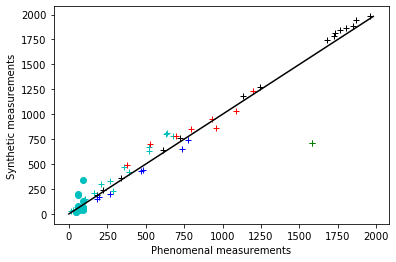

In [21]:
df = pandas.DataFrame(registred_rows)
# df = df[df["distance_registration"] < 100]
# df_filtred_label = df[df["pm_label"] == "mature_leaf"]

# print df["sm_inclination_angle"], df["pm_inclination_angle"], 

plt.plot(df["sm_full_length"], df["pm_full_length"], "k+")
plt.plot(df["sm_surface"] / 100.0, df["pm_surface"] / 100.0, "c+")
plt.plot(df["sm_inclination_angle"] * 100.0, df["pm_inclination_angle"] * 100.0, "co")
for label, color in [("mature_leaf", "b+"), ("growing_leaf", "r+"), ("stem", "g+")]:
    df_filtred_label = df[df["pm_label"] == label]
    plt.plot(df_filtred_label["sm_length"], df_filtred_label["pm_length"], color)

plt.plot(df_filtred_label["sm_length"], df_filtred_label["pm_length"], color)
plt.xlabel("Phenomenal measurements")
plt.ylabel("Synthetic measurements")

m = int(max([df[k].max() for k in ["pm_length", "sm_length", "pm_full_length", "sm_full_length"]]))
plt.plot(range(m), range(m), 'k-')